In [5]:
import numpy as np
import pandas as pd
from astropy.io import fits
import datetime 
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os
import sys
sys.path.append('../radiospectra2')

from radiospectra.sources import CallistoSpectrogram
from matplotlib.axis import Axis  
from matplotlib.ticker import MaxNLocator, IndexLocator
from scipy import interpolate
from copy import deepcopy
import matplotlib.ticker as ticker
from matplotlib.dates import MinuteLocator
import cv2

/home/delberin/eCallistoValidation/validation/Orfees/../radiospectra2/radiospectra/version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


In [223]:
# final Version

class OrfeesSpectrogram():
    
    def __init__(self, file=None,  t_label="Time",  f_label="Frequency"):
        data = {}
        
        if file:
            data = self.read_orfees(file)
               
        self.__init_values__(**data)
            
    def __init_values__(self, **kwargs):
        self.data = kwargs.get("data", None)
        self.time_axis = kwargs.get("time_axis", None)
        self.freq_axis = kwargs.get("freq_axis", None)
        self.date_obs = kwargs.get("date_obs", None)
        self.time_start_obs = kwargs.get("time_start_obs", None)
        self.time_end_obs = kwargs.get("time_end_obs", None)

        self.t_label = kwargs.get("t_label", None)
        self.f_label = kwargs.get("f_label", None)
  

    def read_orfees(self, filename):
        hdulist=fits.open(filename)

        h_file = hdulist[0].header   # Header file
        frequency = hdulist[1].data  # data Extend1 (ferquency)
        h_data = hdulist[2].data     # data Extend2 (data)


        date_obs = h_file[4]         # Date observation start
        time_start_obs = h_file[5]   # Time observation start
        time_end_obs = h_file[7]     # Date observation End
      

        # STOKESI_B: nata for Stokes parameter I (STOKESI) per bann
        data_SI_B1 = h_data.STOKESI_B1
        data_SI_B2 = h_data.STOKESI_B2
        data_SI_B3 = h_data.STOKESI_B3
        data_SI_B4 = h_data.STOKESI_B4
        data_SI_B5 = h_data.STOKESI_B5

        # TIME_B: Time in seconn per band
        time_1 = h_data.TIME_B1
        time_2 = h_data.TIME_B2
        time_3 = h_data.TIME_B3
        time_4 = h_data.TIME_B4
        time_5 = h_data.TIME_B5

        # The Frequency 
        freq_b1=frequency.FREQ_B1[0]
        freq_b2=frequency.FREQ_B2[0]
        freq_b3=frequency.FREQ_B3[0]
        freq_b4=frequency.FREQ_B4[0]
        freq_b5=frequency.FREQ_B5[0]
        
        # concatenate all together using np.concatenate
        time_axis = np.concatenate([time_1, time_2, time_3, time_4, time_5])
        freq_axis = np.concatenate([freq_b1,freq_b2,freq_b3,freq_b4,freq_b5])
        data = np.concatenate([data_SI_B1,data_SI_B2,data_SI_B3,data_SI_B4,data_SI_B5],axis=1)

        return {
            "data": data,  #[:, 240:370],
            "time_axis": time_axis,
            "freq_axis": freq_axis,
            "date_obs": date_obs,
            "time_start_obs": time_start_obs,
            "time_end_obs": time_end_obs
        }


    def resize(self, target_shape):
        return cv2.resize(self.data.transpose(), target_shape, cv2.INTER_CUBIC)
    

    def convert_ms_to_date(self):
        list_of_times = []
        for time in self.time_axis:
            delta = datetime.timedelta(0, 0, 0, int(time))
            list_of_times.append(str(delta).split(".")[0])

        return list_of_times
    
    
    def time_range(self, start_time, end_time):

        converted_times = self.convert_ms_to_date()
        start_index = converted_times.index(start_time)
        end_index = converted_times.index(end_time)
        return self.data[start_index:end_index+1]
    

    def peek(self, start_time=None, end_time=None):
            converted_times = self.convert_ms_to_date()
            dates = self.convert_ms_to_date()
            fig, ax = plt.subplots()
            
            if start_time is not None and end_time is not None:
                data = self.time_range(start_time, end_time)
                time_axis = self.time_axis[converted_times.index(start_time):converted_times.index(end_time)+1]
            else:
                data = self.data
                time_axis = self.time_axis

            ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
            ax.set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")

            xmin = min(time_axis)
            xmax = max(time_axis)
            ymin = min(self.freq_axis)
            ymax = max(self.freq_axis)
            
            plt.imshow(data.T, vmin=data.min(), origin='lower', vmax=1000, aspect='auto', extent=[xmin, xmax, ymin, ymax])
            plt.colorbar()
            # ax.get_xlim(xmin, xmax)
            plt.gca().set_ylim(ymax, ymin)
            
            plt.title(f"ORFEES, {self.date_obs}")
            plt.xlabel('Time[UT]')
            plt.ylabel('Frequency [MHz]')

            plt.show()

/tmp/ipykernel_647/1126401280.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")


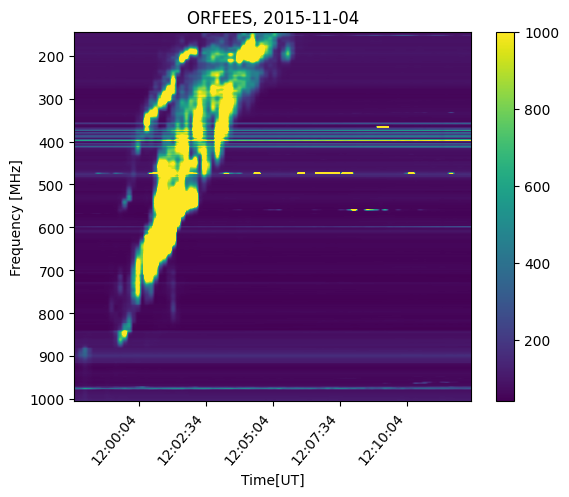

In [229]:
orfees_1 = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
orfees_1.peek()


/tmp/ipykernel_647/1126401280.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")


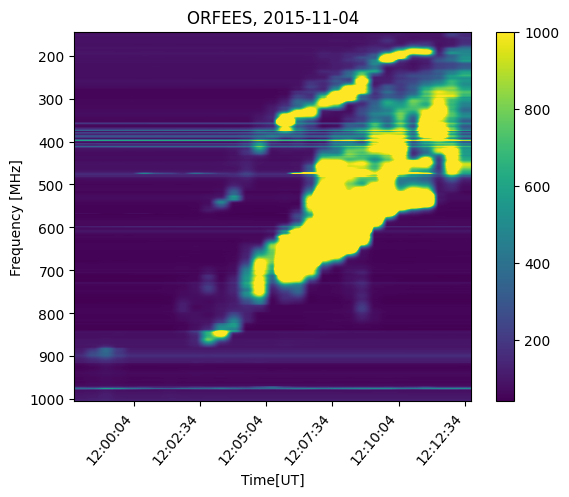

In [232]:
# still have to fix the the x axis to plot the correct time after using the range time:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_10.fts")
orfees.peek(start_time='12:00:04', end_time='12:05:04')

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

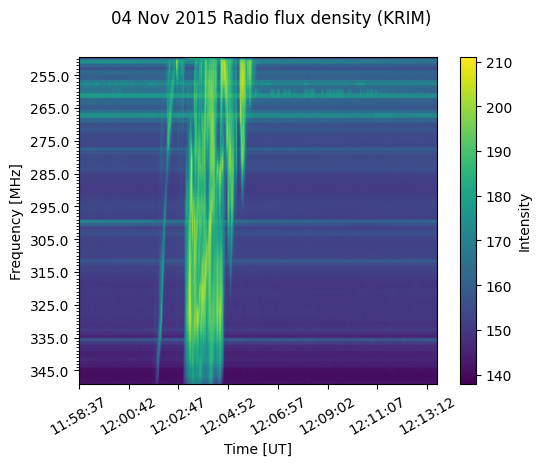

In [212]:
spec3 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/KRIM_20151104_115837_00.fit.gz')
spec3.plot()

In [233]:
# spec2 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
# spec3 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/KRIM_20151104_115837_00.fit.gz')
# spec4 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/HB9SCT_20151104_120000_59.fit.gz')
# spec5 = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/GLASGOW_20151104_120000_59.fit.gz')

# plt.plot(spec2.data[50])
# plt.plot(spec3.data[50])
# plt.plot(spec4.data[50])
# plt.plot(spec5.data[50])
# plt.plot(with_resize[50])
# plt.yscale("log")
# plt.show()


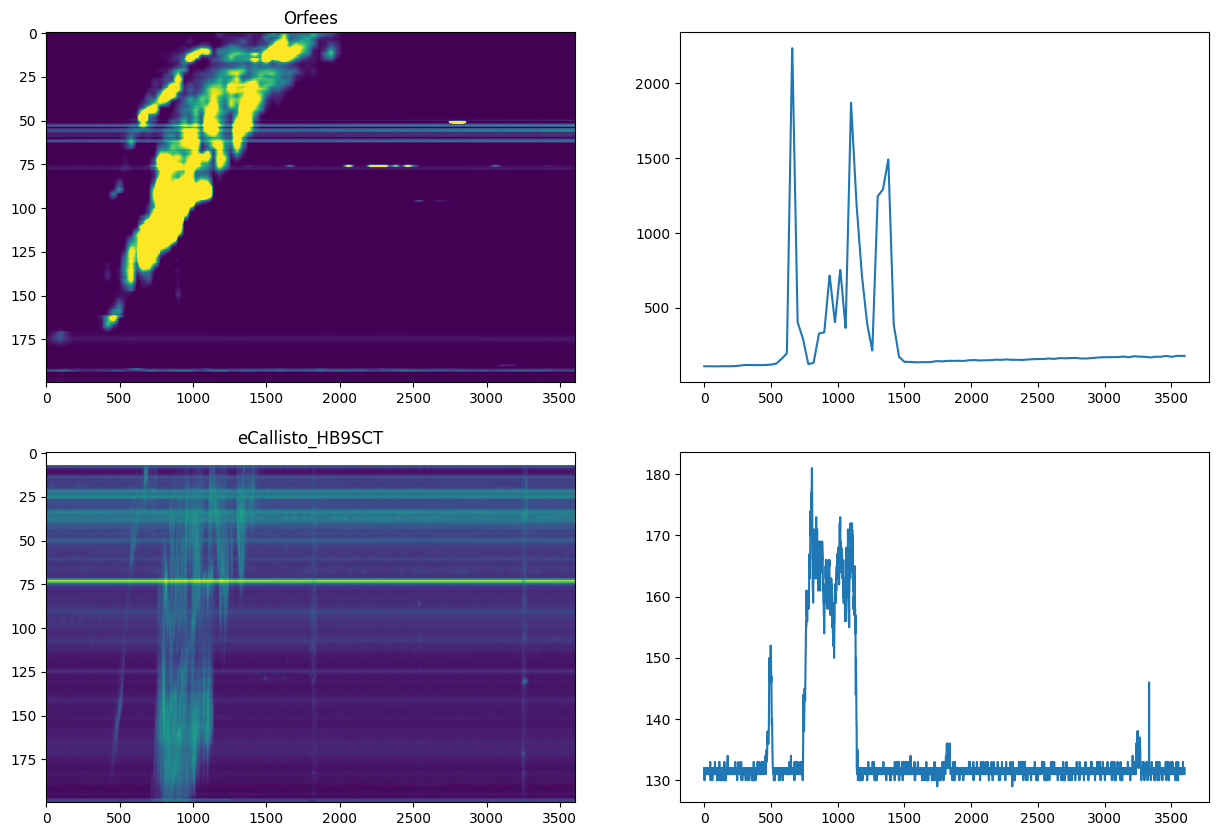

In [204]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(with_resize,vmin=100, vmax=1000, aspect="auto")
axs[0, 0].set_title("Orfees")
axs[1, 0].imshow(spec4.data[::-1], aspect="auto")
axs[1, 0].set_title("eCallisto_HB9SCT")
axs[0, 1].plot(with_resize[50])
axs[1, 1].plot(spec4.data[50])

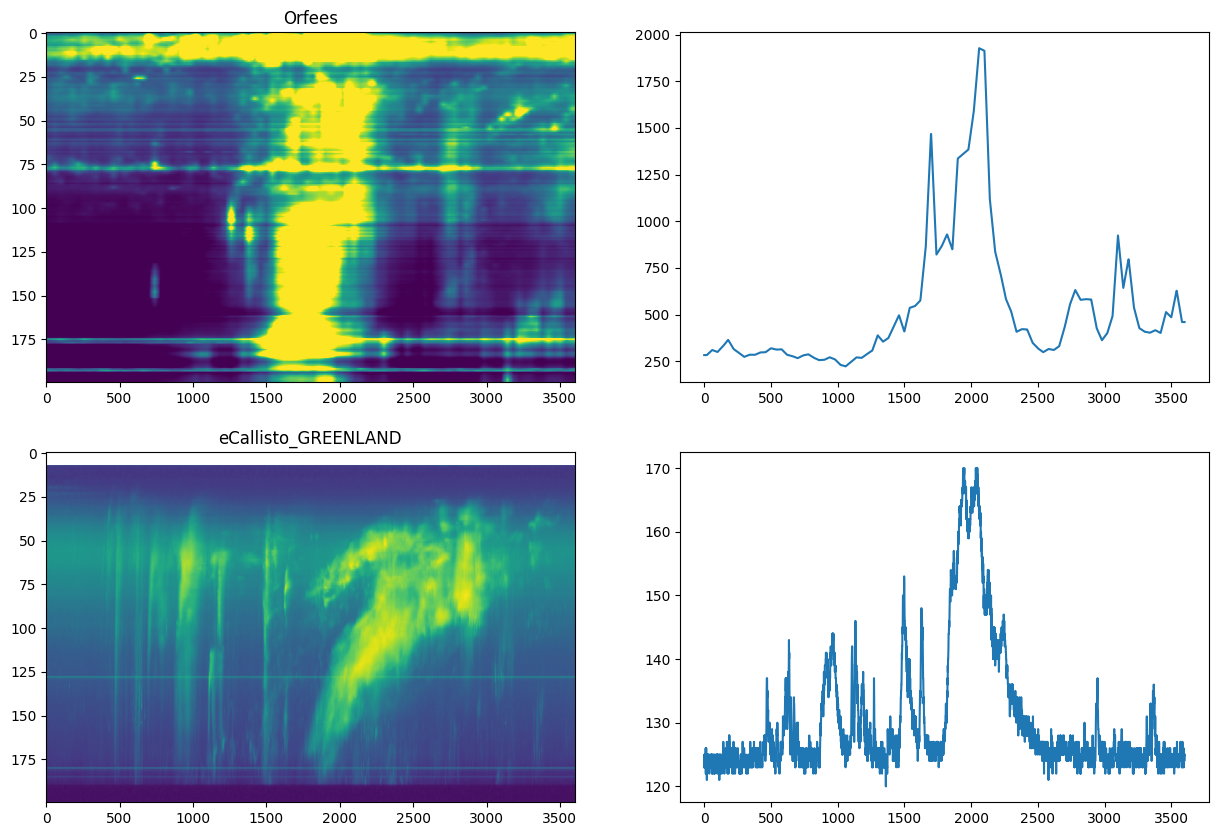

In [185]:
orfees_2 = OrfeesSpectrogram("./orfees_files/int_orf20170906_115500_10 (1).fts")
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2017/09/06/GREENLAND_20170906_115514_62.fit.gz')

_data = orfees_2.resize((spec.shape[1],spec.shape[0])) #[:, :200]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].imshow(_data,vmin=100, vmax=1000, aspect="auto")
axs[0, 0].set_title("Orfees")
axs[1, 0].imshow(spec.data[::-1], aspect="auto")
axs[1, 0].set_title("eCallisto_GREENLAND")
axs[0, 1].plot(_data[50])
axs[1, 1].plot(spec.data[50])

/tmp/ipykernel_647/2409004952.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


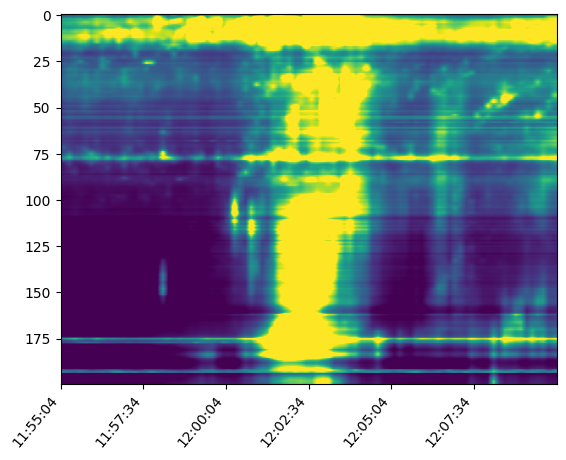

In [234]:
orfees3 = OrfeesSpectrogram("./orfees_files/int_orf20170906_115500_10 (1).fts")

spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2017/09/06/GREENLAND_20170906_115514_62.fit.gz')
fig, ax = plt.subplots()
# # taking the shape of the ecallisto spec:
resized_shape  = orfees3.resize((spec.shape[1],spec.shape[0]))
dates = orfees3.convert_ms_to_date()

ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")

plt.imshow(resized_shape,vmin=100, vmax=1000, aspect="auto")

/tmp/ipykernel_647/3575315462.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")


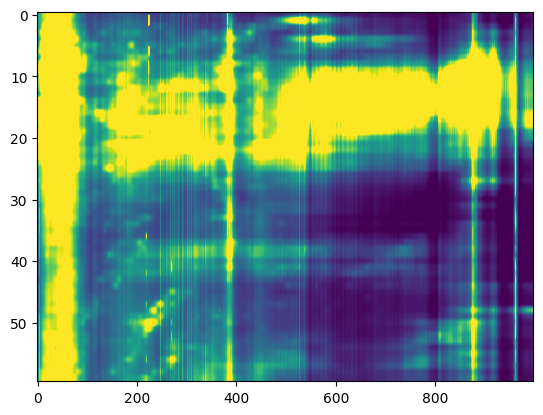

In [235]:
orfees3 = OrfeesSpectrogram("./orfees_files/int_orf20170906_115500_10 (1).fts")


dates = orfees3.convert_ms_to_date()
new_range = orfees3.time_range(start_time='12:00:04', end_time='12:09:54')

ax.xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
ax.set_xticklabels(dates[::int(len(dates)//30 )], rotation = 50, horizontalalignment="right")

plt.imshow(new_range,vmin=100, vmax=1000, aspect="auto")
